# MAT281 - Tarea N°02


## Instrucciones

1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.


* __Nombre__: Alexei Arenas Bahamondes

* __Rol__: 201910513-2

2.- Debes _subir_ este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:
   - Soluciones
   - Código
   - Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.
   
4.- Esta Tarea debe ser entregada en **Dos Jupyter Notebooks Distinto**.
   * **Ejemplo**: `hw_02_part_01.ipynb`, `hw_02_part_02.ipynb`.

# Titanic - Machine Learning from Disaster

El desafío Titanic - Machine Learning from Disaster en Kaggle invita a predecir qué pasajeros sobrevivieron al naufragio del Titanic mediante un modelo de machine learning. Utiliza datos reales de los pasajeros, como su nombre, edad, género y clase socioeconómica, para explorar patrones de supervivencia y construir un modelo predictivo. Este es uno de los desafíos más populares de Kaggle y un excelente punto de partida para aprender sobre machine learning y análisis de datos.

## Cargar Datos

Instalar xgboost si es necesario

In [18]:
#%pip install xgboost

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

#Configuración matplotlib
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'
sns.set_style('whitegrid')
sns.set_palette('colorblind')

#Cargar datos
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Análisis Exploratorio

In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Veamos los datos estadísticos de las columnas numéricas

In [25]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Además, observemos si hay columnas con datos faltantes en ambos conjuntos de datos

In [28]:
print(train_data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [30]:
print(test_data.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Visualizemos variables relevantes para el problema

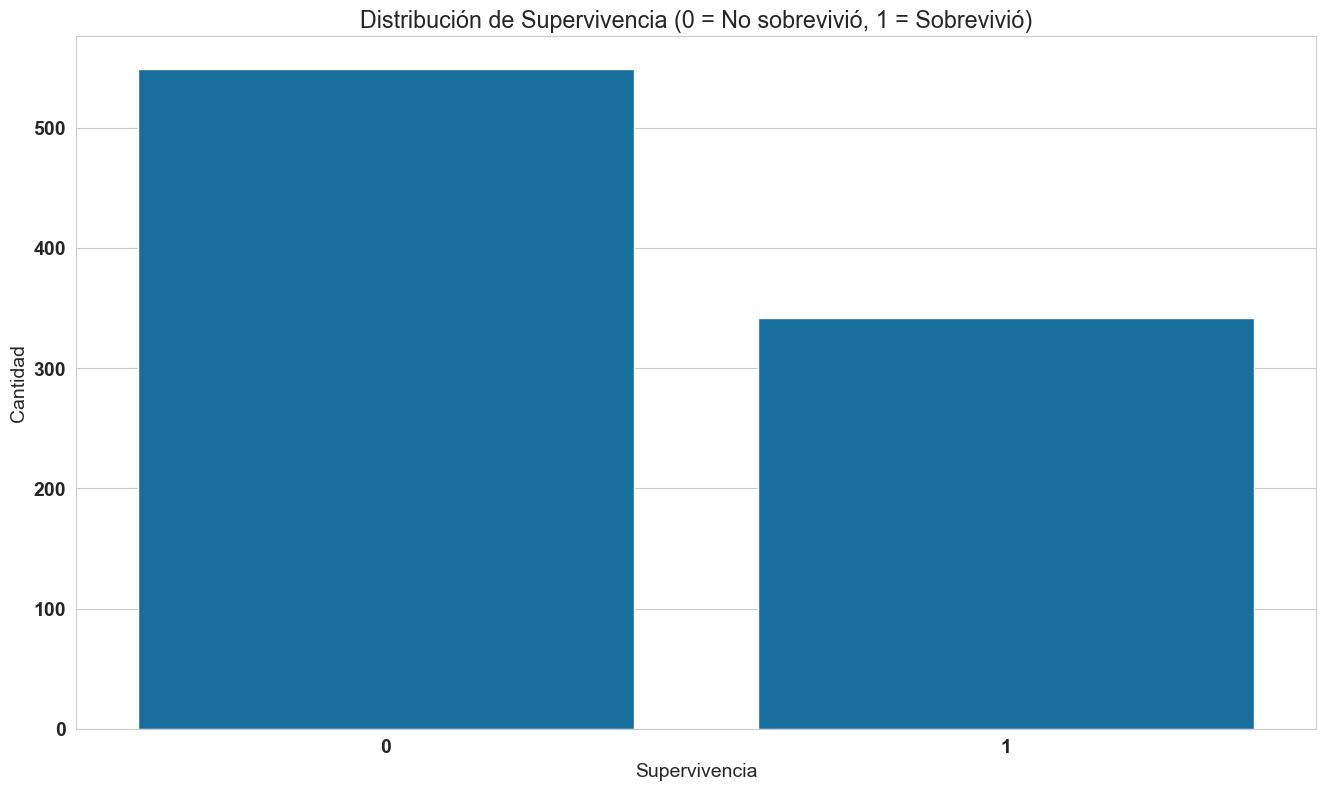

In [33]:
sns.countplot(data=train_data, x='Survived')
plt.title("Distribución de Supervivencia (0 = No sobrevivió, 1 = Sobrevivió)")
plt.xlabel("Supervivencia")
plt.ylabel("Cantidad")
plt.show()

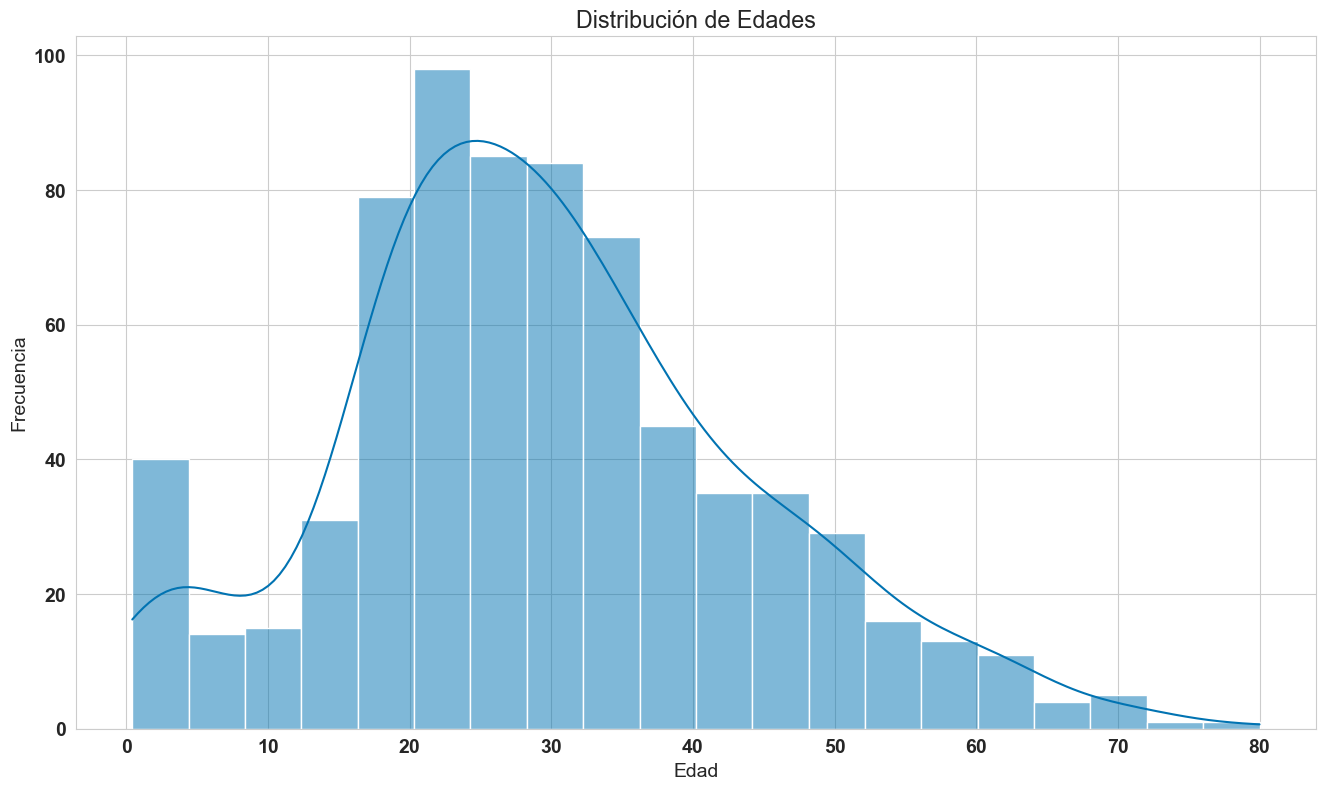

In [35]:
sns.histplot(data=train_data, x='Age', kde=True, bins=20)
plt.title("Distribución de Edades")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()

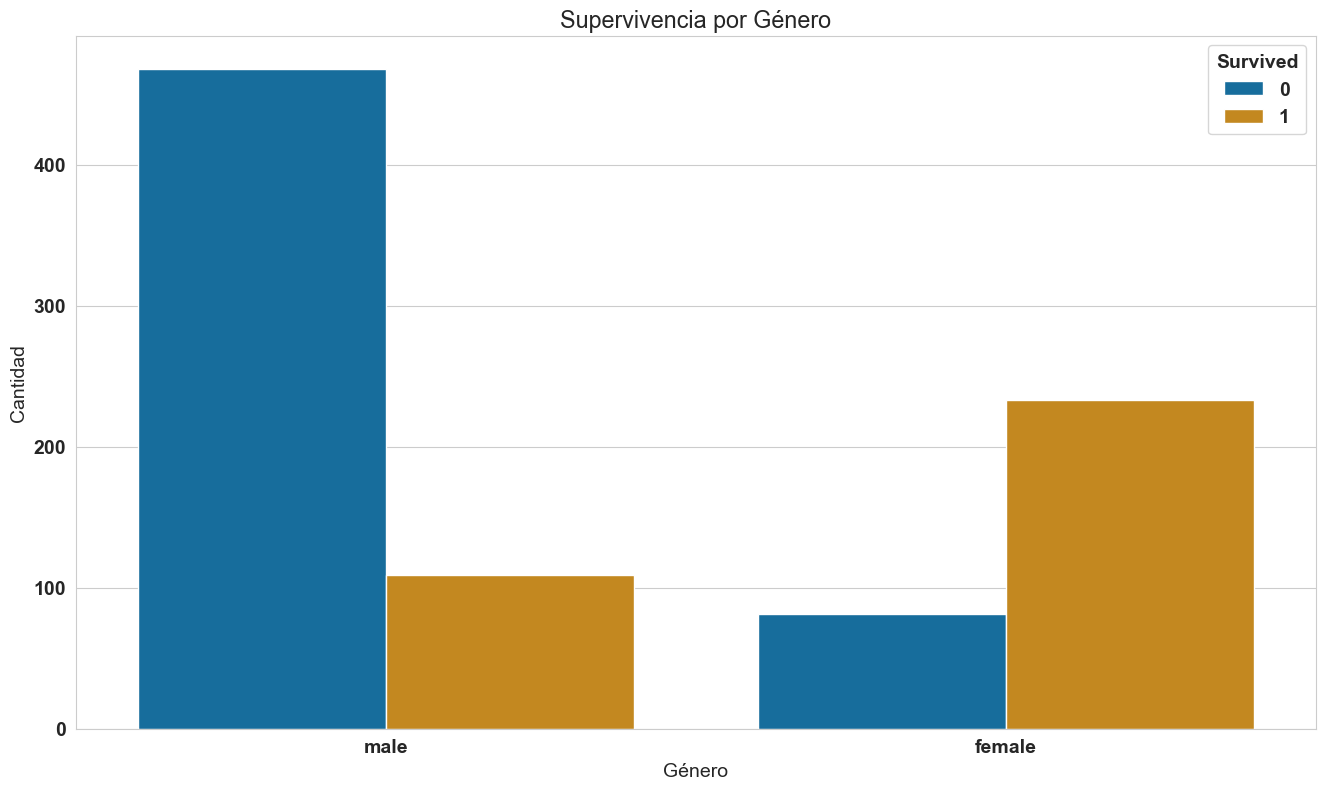

In [37]:
sns.countplot(data=train_data, x='Sex', hue='Survived')
plt.title("Supervivencia por Género")
plt.xlabel("Género")
plt.ylabel("Cantidad")
plt.show()

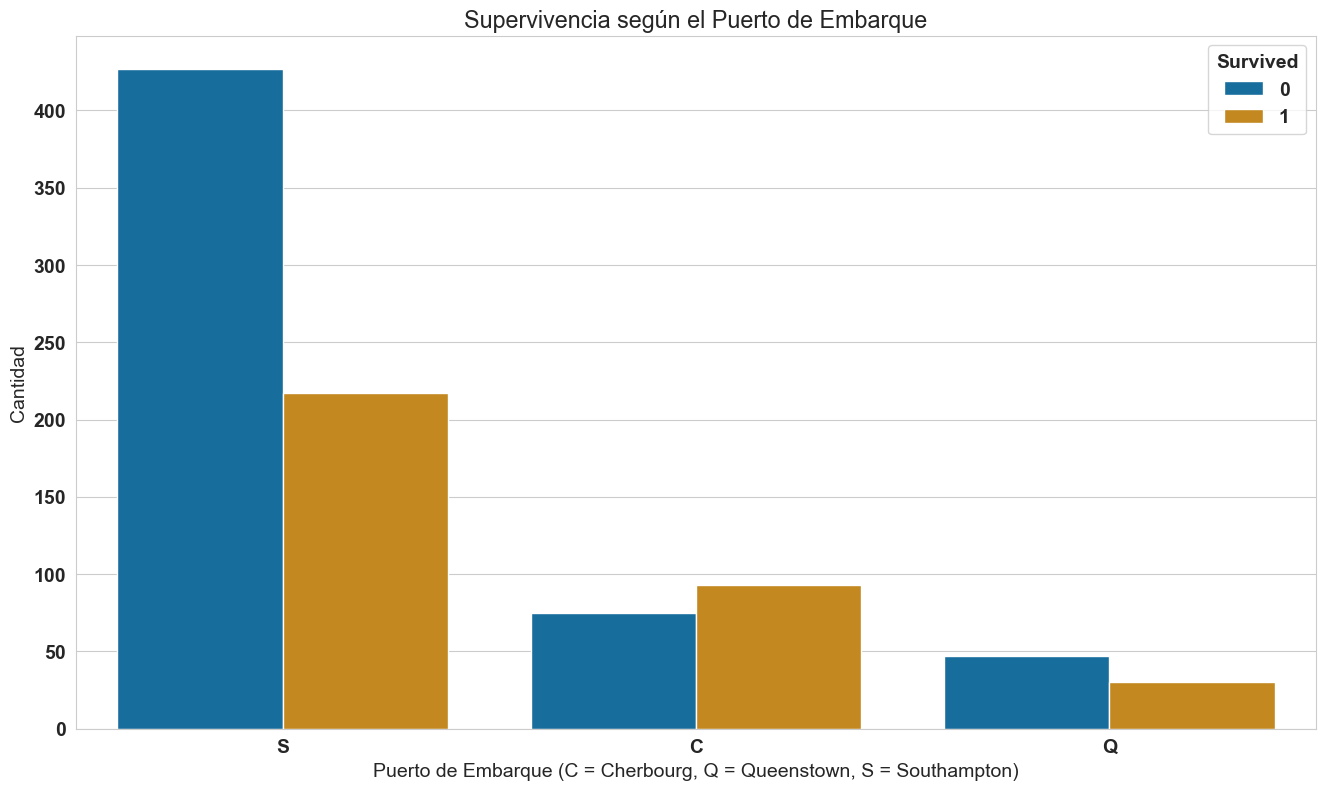

In [39]:
sns.countplot(data=train_data, x='Embarked', hue='Survived')
plt.title("Supervivencia según el Puerto de Embarque")
plt.xlabel("Puerto de Embarque (C = Cherbourg, Q = Queenstown, S = Southampton)")
plt.ylabel("Cantidad")
plt.show()

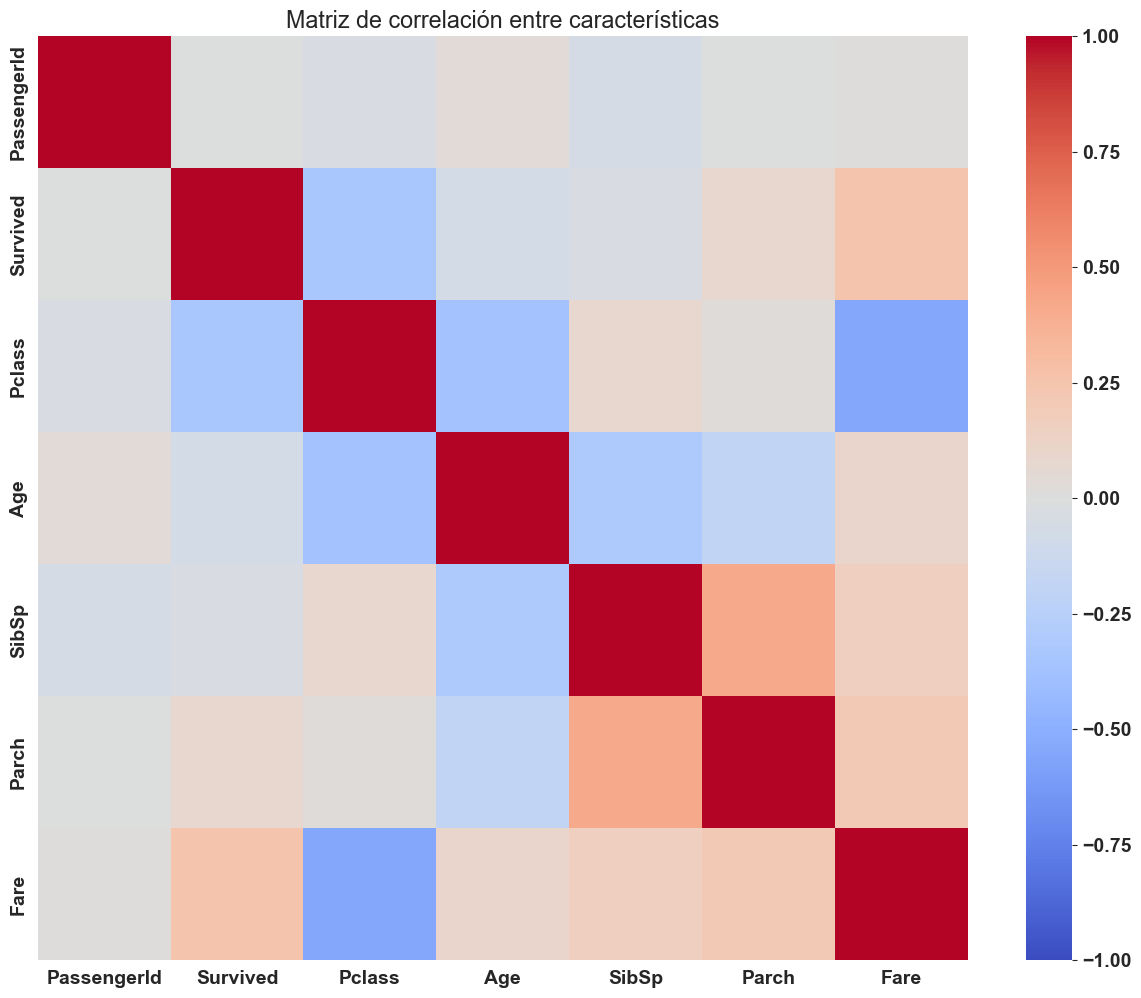

In [41]:
plt.figure(figsize=(15,12))
numerical_data = train_data.select_dtypes(include=np.number)
correlation_matrix = numerical_data.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de correlación entre características")
plt.show()

## Preprocesamiento

Rellenamos los valores faltantes

In [47]:
train_data['Age'] = train_data.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.median())).reset_index(level=[0,1], drop=True) # Reset the index
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])

Eliminamos las columnas irrelevantes para el modelo (repetitivas o que no aportan información)

In [50]:
train_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

Convertimos las variables categoricas a numéricas

In [53]:
train_data = pd.get_dummies(train_data, columns=['Sex', 'Embarked'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['Sex', 'Embarked'], drop_first=True)

In [55]:
train_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,True


## Modelo Random Forest

Definimos las variables y dividimos la data en conjunto de entrenamiento y validación

In [61]:
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']

#Divimos la data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Creamos el modelo y lo entrenamos

In [64]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Ahora evaluamos el modelo en el cojunto de validación

In [67]:
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print(f"Exactitud del modelo en el conjunto de validación: {accuracy:.2f}")
print("\nInforme de clasificación:")
print(classification_report(y_val, y_pred))

Exactitud del modelo en el conjunto de validación: 0.82

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       105
           1       0.78      0.77      0.78        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



Graficamos la matriz de confusión

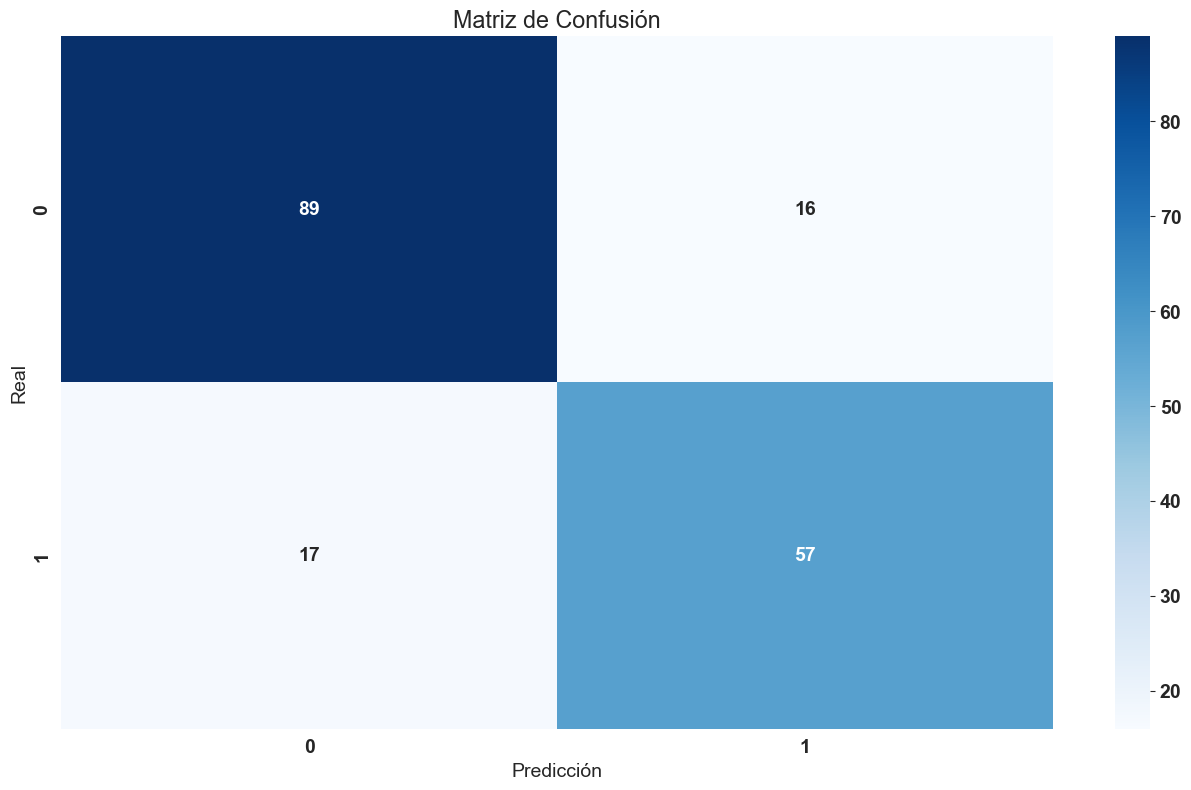

In [72]:
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

Balanceamos los pesos de las clases

In [75]:
rf_balanced = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_balanced.fit(X_train, y_train)

# Evaluar
y_pred_balanced = rf_balanced.predict(X_val)
accuracy_balanced = accuracy_score(y_val, y_pred_balanced)
print(f"Exactitud con pesos balanceados: {accuracy_balanced:.2f}")

Exactitud con pesos balanceados: 0.83


Realizamos validación cruzada para verificar la efectividad del modelo

In [78]:
cv_scores = cross_val_score(rf_balanced,
                            X, y, cv=5, scoring='accuracy')

print(f"Exactitud promedio en validación cruzada: {cv_scores.mean():.2f}")

Exactitud promedio en validación cruzada: 0.81


Se observa que es menor a la evaludada.

## Modelo XGBoost

Creamos el modelo y lo entrenamos

In [83]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Evaluamos el modelo en el conjunto de validación

In [85]:
y_pred_xgb = xgb_model.predict(X_val)
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
print(f"Exactitud del modelo XGBoost: {accuracy_xgb:.2f}")

Exactitud del modelo XGBoost: 0.82


Realizamos un ajuste de hiperparámetros y guardamos el mejor modelo

In [89]:
#Definir la rejilla de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

#Configurar GridSearchCV
grid_search_xgb = GridSearchCV(estimator=XGBClassifier(random_state=42),
                               param_grid=param_grid,
                               cv=5,
                               scoring='accuracy',
                               verbose=1,
                               n_jobs=-1)

#Ejecutar GridSearch
grid_search_xgb.fit(X_train, y_train)

#Guardar el mejor modelo
best_xgb_model = grid_search_xgb.best_estimator_
print("Mejores parámetros para XGBoost:", grid_search_xgb.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores parámetros para XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


Evaluamos el mejor modelo xgb en el conjunto de validación

In [94]:
y_pred_best_xgb = best_xgb_model.predict(X_val)
accuracy_best_xgb = accuracy_score(y_val, y_pred_best_xgb)
print(f"Exactitud del modelo XGBoost optimizado: {accuracy_best_xgb:.2f}")

Exactitud del modelo XGBoost optimizado: 0.82


In [96]:
cv_scores_xgb = cross_val_score(best_xgb_model, X, y, cv=5, scoring='accuracy')
print(f"Exactitud promedio en validación cruzada (XGBoost optimizado): {cv_scores_xgb.mean():.2f}")

Exactitud promedio en validación cruzada (XGBoost optimizado): 0.82


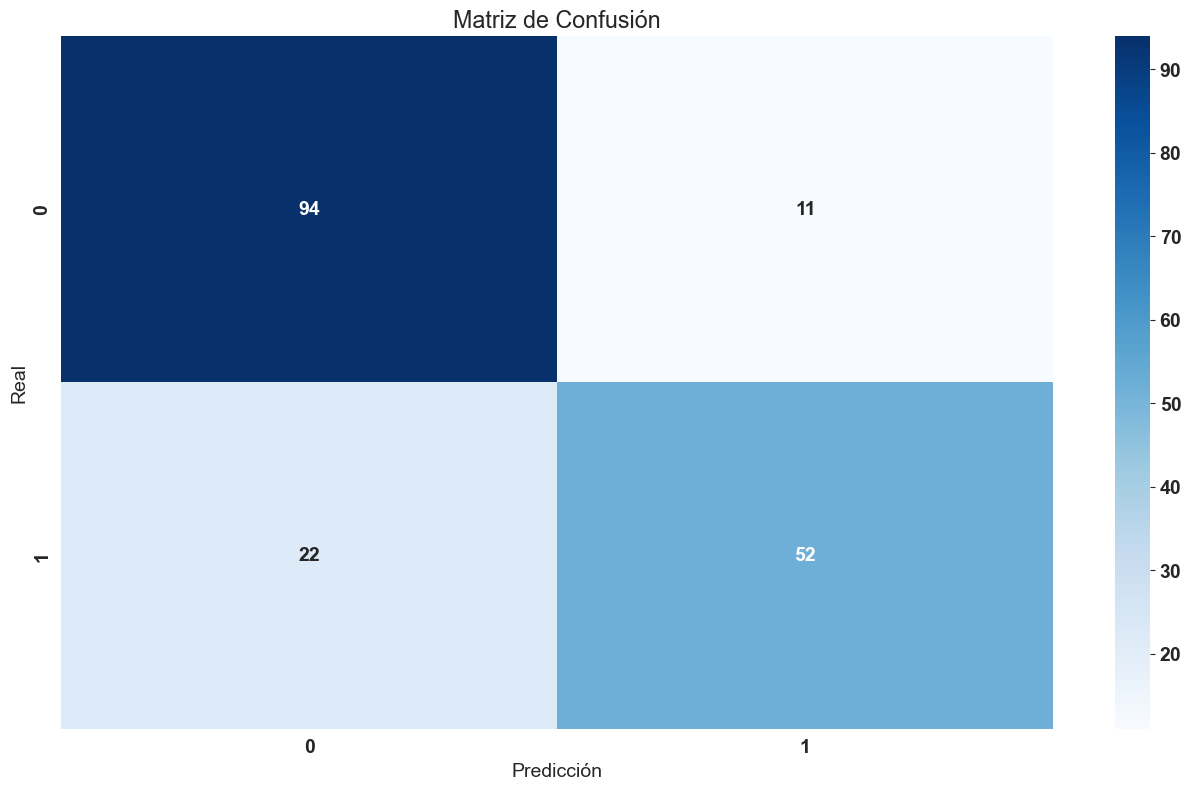

In [98]:
conf_matrix = confusion_matrix(y_val, y_pred_best_xgb)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

Conclusión: Elegimos como modelo final a XGBoost, ya que muestra mejores resultados en la precisión en promedio luego de la validación cruzada

## Predicciones

Generamos las predicciones para el mejor modelo encontrado

In [105]:
X_test = test_data.drop('Survived', axis=1, errors='ignore')
test_predictions = best_xgb_model.predict(X_test)

Creamos el archivo "submission.csv" y lo guardamos

In [110]:
submission = pd.DataFrame({
    'PassengerId': pd.read_csv("data/test.csv")['PassengerId'],
    'Survived': test_predictions
})

# Guardar el archivo CSV
submission.to_csv("data/submission.csv", index=False)
print("Archivo de sumisión creado: 'submission.csv'")

Archivo de sumisión creado: 'submission.csv'


Este archivo luego debe ser subido a Kagle para participar de la competencia.